In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Getting Started 
Make sure your select ***ros_base*** as your kernel. You can do this by clicking on the kernel dropdown menu and selecting *ros_base*.


## Import Python dependencies

In [34]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation, cm
from IPython.display import HTML
import numpy as np
import csv

import tqdm as tqdm


plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

from ILQR import RefPath
from ILQR import ILQR



In [35]:
def load_path(filepath: str):
    """
    Gets the centerline of the track from the trajectory data. We currently only
    support 2D track.

    Args:
        filepath (str): the path to file consisting of the centerline position.

    Returns:
        np.ndarray: centerline, of the shape (2, N).
    """
    x = []
    y = []
    with open(filepath) as f:
        spamreader = csv.reader(f, delimiter=',')
        for i, row in enumerate(spamreader):
            if i > 0:
                x.append(float(row[0]))
                y.append(float(row[1]))

    return np.array([x, y])

## Generate a reference trajectory

In [36]:
# Define the file paths
config_file = 'task1/task1.yaml'
track_path = 'task1/ref_path.csv'

# Load the reference path
x = []
y = []
left_width = []
right_width = []
with open(track_path, newline='') as f:
    spamreader = csv.reader(f, delimiter=',')
    for i, row in enumerate(spamreader):
        if i>0:
            x.append(float(row[0]))
            y.append(float(row[1]))
            left_width.append(float(row[3]))
            right_width.append(float(row[2]))
            
x = np.array(x)/30.0
y = np.array(y)/30.0
left_width = np.array(left_width)
right_width = np.array(right_width)
center_line = np.array([x,y])


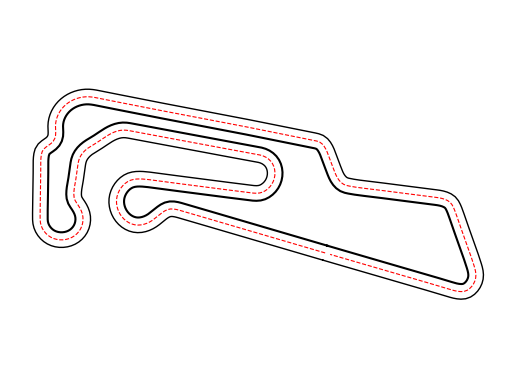

In [24]:
# Create a reference path
ref_path = RefPath(center_line, width_left = 0.6, width_right = 0.6, speed_limt = 5, loop = True)

# Visualize the reference path
ref_path.plot_track(linewidth = 1)
ref_path.plot_track_center(linewidth = 0.8, c='r')
plt.axis('equal')
_ = plt.axis('off')


## Test your ILQR planner
The planner need to warmup for a few steps for the first time it is run. This process will takes 10-30 seconds depending on your computer.

In [172]:
ilqr = ILQR(config_file)
ilqr.update_ref_path(ref_path)


Line Search Alphas:  [10.    1.    0.1   0.01]
ILQR setting: ILQR config: {'num_dim_x': 5, 'num_dim_u': 2, 'T': 10, 'dt': 0.1, 'platform': 'cpu', 'max_iter': 50, 'tol': 0.05, 'line_search_base': 0.1, 'line_search_a': -1, 'line_search_b': 3, 'line_search_c': 1, 'reg_min': '1e-5', 'reg_max': '1e8', 'reg_scale_down': 5, 'reg_scale_up': 5, 'reg_init': 1.0, 'max_attempt': 5, 'wheelbase': 0.257, 'radius': 0.13, 'width': 0.22, 'length': 0.4, 'delta_max': 0.35, 'delta_min': -0.35, 'v_max': 5.0, 'v_min': 0.0, 'omega_min': -6.0, 'omega_max': 6.0, 'a_max': 5.0, 'a_min': -5.0, 'v_ref': 5.0, 'dim_closest_pt_x': 0, 'dim_closest_pt_y': 1, 'dim_path_slope': 2, 'path_cost_type': 'quadratic', 'path_weight': 2.0, 'path_huber_delta': 2, 'vel_cost_type': 'quadratic', 'vel_weight': 0.2, 'vel_huber_delta': 1, 'dim_vel_limit': 3, 'vel_limit_a': 10.0, 'vel_limit_b': 1.0, 'heading_cost_type': 'quadratic', 'heading_weight': 1, 'heading_huber_delta': 1, 'lat_accel_thres': 6.0, 'lat_accel_a': 5.0, 'lat_accel_b': 2

### Plan for one step

line search failed with reg =  0.0625  at step  3


Text(0.5, 1.0, 'Lateral Acceleration')

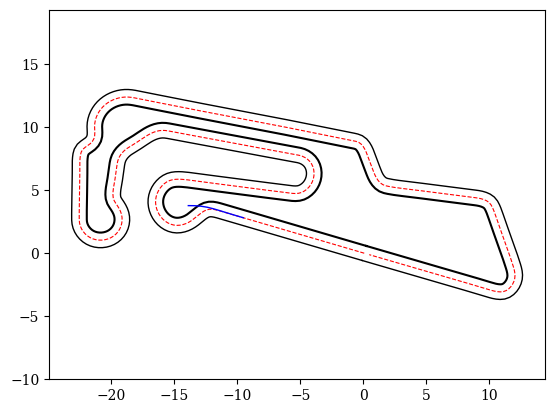

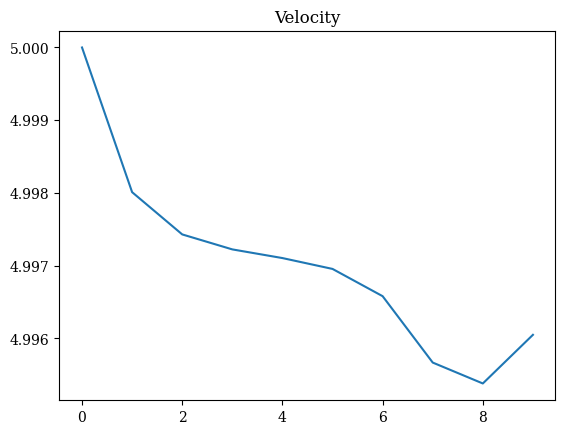

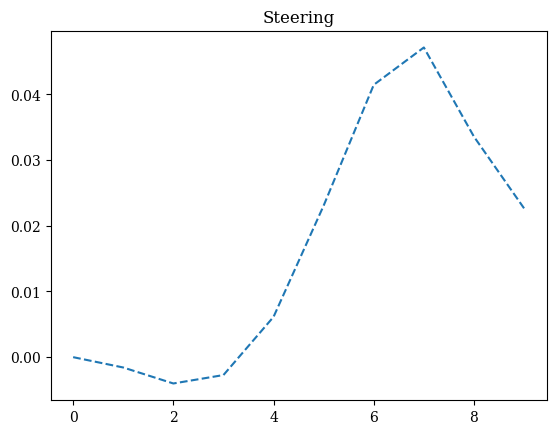

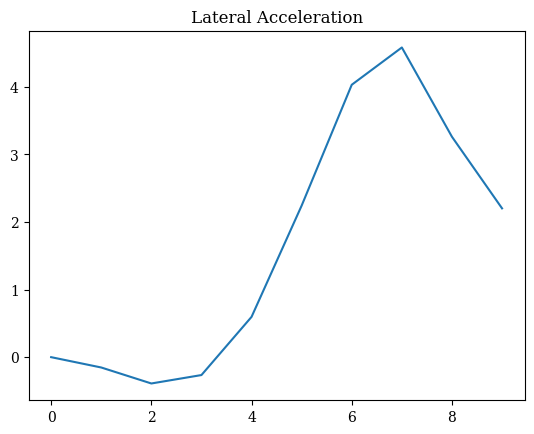

In [173]:
# Create an ILQR solver
x_init = np.array([x[60], y[60], 5, np.arctan2(y[61]-y[60], x[61]-x[60]), 0])
plan = ilqr.plan(x_init)
# Visualize the reference path
ref_path.plot_track(linewidth = 1)
ref_path.plot_track_center(linewidth = 0.8, c='r')
plt.plot(plan['trajectory'][0, :], plan['trajectory'][1, :], 'b-', linewidth=1)
plt.axis('equal')

plt.figure()
a = plan['trajectory'][2, :] 
plt.plot(a)
plt.title('Velocity')

plt.figure()
# plt.plot(plan['controls'][0,:])
plt.plot(plan['trajectory'][-1,:], '--')
plt.title('Steering')

plt.figure()
a = plan['trajectory'][2, :]**2 / 0.257 * np.tan(plan['trajectory'][-1, :])
plt.plot(a)
plt.title('Lateral Acceleration')


### Plan for the entire track

In [174]:
itr_receding = 400
init_control = np.zeros((2, ilqr.T))
x_cur = np.array([x[0], y[0], 4, np.arctan2(y[1]-y[0], x[1]-x[0]), 0])
state_history = np.zeros((5,itr_receding + 1))
state_history[:,0] = x_cur
plan_history = np.zeros((5, ilqr.T, itr_receding))
control_history = np.zeros((2,itr_receding))
t_process = np.zeros(itr_receding)
for i in (pbar := tqdm.tqdm(range(itr_receding))):
    plan = ilqr.plan(x_cur, init_control)
    
    trajectory = plan['trajectory']
    controls = plan['controls']
    
    # record the state and control
    state_history[:,i+1]  = trajectory[:,1]
    control_history[:,i] = controls[:,0]
    plan_history[:,:,i] = trajectory
    t_process[i] = plan['t_process']
    
    # prepare for next iteration
    x_cur = trajectory[:,1] 
    init_control[:,:-1] = controls[:,1:]
    
    pbar.set_description(f"ILQR takes : {plan['t_process']:.2f} sec']")

ILQR takes : 0.01 sec']:   2%|▏         | 7/400 [00:00<00:05, 69.47it/s]

ILQR takes : 0.02 sec']:   4%|▍         | 17/400 [00:00<00:04, 85.07it/s]

line search failed with reg =  0.0625  at step  3
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
line search failed with reg =  0.5  at step  0
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
line search failed with reg =  0.5  at step  0
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
line search failed with reg =  0.5  at step  0


ILQR takes : 0.05 sec']:   6%|▋         | 26/400 [00:00<00:05, 73.02it/s]

line search failed with reg =  0.25  at step  1
converged after  0  steps.
converged after  6  steps.
converged after  0  steps.
line search failed with reg =  0.5  at step  0
line search failed with reg =  0.5  at step  0
line search failed with reg =  0.5  at step  0
line search failed with reg =  0.5  at step  0
line search failed with reg =  0.5  at step  0
line search failed with reg =  0.5  at step  0
line search failed with reg =  76.2939453125  at step  9


ILQR takes : 0.19 sec']:   6%|▋         | 26/400 [00:00<00:05, 73.02it/s]

line search failed with reg =  97.65625  at step  4
converged after  24  steps.


ILQR takes : 0.01 sec']:  10%|█         | 41/400 [00:00<00:08, 42.85it/s]

converged after  8  steps.
line search failed with reg =  0.0625  at step  3
line search failed with reg =  0.5  at step  0
line search failed with reg =  0.5  at step  0
line search failed with reg =  0.5  at step  0
line search failed with reg =  0.015625  at step  5
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1


ILQR takes : 0.02 sec']:  14%|█▍        | 55/400 [00:01<00:06, 50.72it/s]

line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.5  at step  0
line search failed with reg =  0.25  at step  1
converged after  0  steps.
converged after  0  steps.
line search failed with reg =  0.5  at step  0


ILQR takes : 0.03 sec']:  16%|█▌        | 62/400 [00:01<00:06, 55.17it/s]

converged after  0  steps.
converged after  0  steps.
line search failed with reg =  0.5  at step  0
converged after  0  steps.
converged after  0  steps.
line search failed with reg =  0.5  at step  0
line search failed with reg =  0.25  at step  1
converged after  0  steps.
line search failed with reg =  0.5  at step  0
line search failed with reg =  12.20703125  at step  7
converged after  6  steps.


ILQR takes : 0.02 sec']:  19%|█▉        | 75/400 [00:01<00:06, 48.43it/s]

converged after  4  steps.
converged after  3  steps.
converged after  3  steps.
converged after  3  steps.
converged after  2  steps.
converged after  2  steps.
line search failed with reg =  0.0625  at step  3
converged after  2  steps.
converged after  2  steps.


ILQR takes : 0.05 sec']:  22%|██▏       | 87/400 [00:01<00:06, 46.26it/s]

line search failed with reg =  0.0625  at step  3
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
converged after  1  steps.
line search failed with reg =  0.25  at step  1
converged after  1  steps.
line search failed with reg =  0.5  at step  0
line search failed with reg =  0.0009765625  at step  9


ILQR takes : 0.01 sec']:  23%|██▎       | 92/400 [00:01<00:07, 42.73it/s]

line search failed with reg =  0.001953125  at step  8
line search failed with reg =  0.5  at step  0
line search failed with reg =  0.000244140625  at step  11
line search failed with reg =  0.5  at step  0
line search failed with reg =  0.5  at step  0
line search failed with reg =  0.5  at step  0
line search failed with reg =  0.5  at step  0


ILQR takes : 0.02 sec']:  26%|██▋       | 105/400 [00:02<00:06, 48.25it/s]

line search failed with reg =  0.00048828125  at step  10
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1


ILQR takes : 0.04 sec']:  29%|██▉       | 115/400 [00:02<00:06, 42.88it/s]

converged after  0  steps.
converged after  0  steps.
line search failed with reg =  0.5  at step  0
line search failed with reg =  0.5  at step  0
line search failed with reg =  0.5  at step  0
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.125  at step  2
converged after  6  steps.


ILQR takes : 0.01 sec']:  30%|███       | 120/400 [00:02<00:06, 42.71it/s]

converged after  1  steps.
converged after  1  steps.
line search failed with reg =  0.25  at step  1
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  1  steps.
converged after  7  steps.
converged after  0  steps.


ILQR takes : 0.09 sec']:  31%|███▏      | 125/400 [00:02<00:07, 38.32it/s]

line search failed with reg =  0.125  at step  2
converged after  2  steps.
converged after  4  steps.


ILQR takes : 0.10 sec']:  32%|███▏      | 129/400 [00:03<00:11, 23.60it/s]

converged after  6  steps.
line search failed with reg =  0.015625  at step  5
line search failed with reg =  0.015625  at step  5


ILQR takes : 0.06 sec']:  33%|███▎      | 133/400 [00:03<00:14, 18.95it/s]

converged after  4  steps.
line search failed with reg =  0.03125  at step  4
converged after  3  steps.


ILQR takes : 0.03 sec']:  34%|███▍      | 136/400 [00:03<00:15, 16.89it/s]

line search failed with reg =  0.03125  at step  4
converged after  5  steps.
converged after  0  steps.


ILQR takes : 0.02 sec']:  35%|███▍      | 139/400 [00:03<00:14, 18.39it/s]

converged after  0  steps.
line search failed with reg =  0.125  at step  2
line search failed with reg =  0.5  at step  0
line search failed with reg =  0.5  at step  0
line search failed with reg =  0.5  at step  0
line search failed with reg =  0.5  at step  0


ILQR takes : 0.04 sec']:  36%|███▋      | 146/400 [00:04<00:12, 20.47it/s]

line search failed with reg =  78.125  at step  2
line search failed with reg =  62.5  at step  0
converged after  5  steps.
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1


ILQR takes : 0.04 sec']:  38%|███▊      | 152/400 [00:04<00:11, 21.90it/s]

line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1


ILQR takes : 0.05 sec']:  39%|███▉      | 155/400 [00:04<00:11, 22.07it/s]

line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
converged after  2  steps.


ILQR takes : 0.05 sec']:  40%|███▉      | 158/400 [00:04<00:12, 19.05it/s]

converged after  6  steps.
converged after  1  steps.
converged after  2  steps.
converged after  1  steps.


ILQR takes : 0.03 sec']:  41%|████      | 164/400 [00:04<00:11, 20.05it/s]

converged after  2  steps.
converged after  1  steps.
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1


ILQR takes : 0.05 sec']:  42%|████▏     | 167/400 [00:05<00:12, 18.42it/s]

converged after  5  steps.
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1


ILQR takes : 0.07 sec']:  42%|████▏     | 169/400 [00:05<00:15, 15.23it/s]

converged after  4  steps.
line search failed with reg =  0.0625  at step  3
converged after  2  steps.


ILQR takes : 0.03 sec']:  44%|████▎     | 174/400 [00:05<00:12, 18.35it/s]

converged after  1  steps.
converged after  0  steps.
converged after  1  steps.
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1


ILQR takes : 0.05 sec']:  45%|████▌     | 180/400 [00:05<00:10, 21.15it/s]

line search failed with reg =  0.25  at step  1
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.


ILQR takes : 0.03 sec']:  47%|████▋     | 187/400 [00:06<00:08, 24.07it/s]

converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.


ILQR takes : 0.02 sec']:  49%|████▉     | 195/400 [00:06<00:06, 29.65it/s]

converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.


ILQR takes : 0.02 sec']:  50%|████▉     | 199/400 [00:06<00:06, 29.56it/s]

converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.


ILQR takes : 0.06 sec']:  52%|█████▏    | 208/400 [00:06<00:06, 31.41it/s]

converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
line search failed with reg =  0.25  at step  1
converged after  2  steps.


ILQR takes : 0.05 sec']:  53%|█████▎    | 212/400 [00:07<00:08, 22.23it/s]

converged after  5  steps.
converged after  7  steps.
line search failed with reg =  0.25  at step  1
converged after  2  steps.


ILQR takes : 0.04 sec']:  54%|█████▍    | 215/400 [00:07<00:08, 21.04it/s]

converged after  1  steps.
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1


ILQR takes : 0.05 sec']:  55%|█████▍    | 218/400 [00:07<00:11, 16.45it/s]

converged after  11  steps.
converged after  5  steps.
converged after  1  steps.


ILQR takes : 0.03 sec']:  56%|█████▌    | 222/400 [00:07<00:11, 16.16it/s]

converged after  3  steps.
line search failed with reg =  0.25  at step  1
converged after  2  steps.
converged after  0  steps.


ILQR takes : 0.03 sec']:  57%|█████▋    | 228/400 [00:08<00:09, 19.05it/s]

line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
converged after  0  steps.
converged after  0  steps.


ILQR takes : 0.05 sec']:  58%|█████▊    | 234/400 [00:08<00:07, 22.29it/s]

converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
line search failed with reg =  0.25  at step  1


ILQR takes : 0.03 sec']:  59%|█████▉    | 237/400 [00:08<00:08, 18.35it/s]

converged after  2  steps.
converged after  7  steps.
line search failed with reg =  0.25  at step  1


ILQR takes : 0.04 sec']:  60%|██████    | 240/400 [00:08<00:08, 18.29it/s]

converged after  4  steps.
converged after  2  steps.
converged after  1  steps.
line search failed with reg =  0.125  at step  2
line search failed with reg =  0.25  at step  1


ILQR takes : 0.03 sec']:  62%|██████▏   | 246/400 [00:08<00:07, 21.72it/s]

line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
converged after  0  steps.
converged after  0  steps.
line search failed with reg =  0.25  at step  1
converged after  1  steps.


ILQR takes : 0.07 sec']:  62%|██████▏   | 249/400 [00:09<00:07, 19.28it/s]

converged after  8  steps.
line search failed with reg =  0.015625  at step  5
line search failed with reg =  0.015625  at step  5


ILQR takes : 0.07 sec']:  64%|██████▎   | 254/400 [00:09<00:09, 15.26it/s]

line search failed with reg =  0.015625  at step  5
line search failed with reg =  0.0078125  at step  6
converged after  5  steps.


ILQR takes : 0.04 sec']:  65%|██████▍   | 259/400 [00:09<00:08, 17.46it/s]

converged after  4  steps.
line search failed with reg =  0.03125  at step  4
converged after  2  steps.
converged after  1  steps.
line search failed with reg =  0.25  at step  1


ILQR takes : 0.01 sec']:  68%|██████▊   | 271/400 [00:09<00:03, 34.43it/s]

line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1


ILQR takes : 0.01 sec']:  70%|██████▉   | 278/400 [00:10<00:02, 42.40it/s]

converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
line search failed with reg =  0.5  at step  0
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.


ILQR takes : 0.00 sec']:  74%|███████▍  | 295/400 [00:10<00:01, 63.02it/s]

converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
line search failed with reg =  0.5  at step  0
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
line search failed with reg =  0.5  at step  0
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
line search failed with reg =  0.5  at step  0
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.


ILQR takes : 0.02 sec']:  79%|███████▉  | 315/400 [00:10<00:01, 73.68it/s]

line search failed with reg =  0.5  at step  0
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.5  at step  0
line search failed with reg =  0.5  at step  0
line search failed with reg =  0.5  at step  0
line search failed with reg =  0.5  at step  0
line search failed with reg =  0.5  at step  0
line search failed with reg =  0.5  at step  0
line search failed with reg =  0.0625  at step  3
line search failed with reg =  0.5  at step  0
line search failed with reg =  156.25  at step  1


ILQR takes : 0.01 sec']:  81%|████████  | 323/400 [00:10<00:01, 48.72it/s]

line search failed with reg =  58.20766091346741  at step  21
converged after  10  steps.
line search failed with reg =  15.625  at step  2
line search failed with reg =  12.5  at step  0
line search failed with reg =  6.25  at step  1
converged after  2  steps.
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1


ILQR takes : 0.02 sec']:  84%|████████▍ | 338/400 [00:11<00:01, 54.97it/s]

line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
converged after  0  steps.
line search failed with reg =  0.5  at step  0


ILQR takes : 0.02 sec']:  88%|████████▊ | 354/400 [00:11<00:00, 62.30it/s]

line search failed with reg =  0.25  at step  1
converged after  0  steps.
converged after  0  steps.
line search failed with reg =  0.5  at step  0
converged after  0  steps.
converged after  0  steps.
line search failed with reg =  0.5  at step  0
converged after  0  steps.
converged after  0  steps.
line search failed with reg =  0.5  at step  0
converged after  4  steps.
line search failed with reg =  0.03125  at step  4
line search failed with reg =  0.5  at step  0


ILQR takes : 0.02 sec']:  90%|█████████ | 361/400 [00:11<00:00, 53.34it/s]

line search failed with reg =  0.001953125  at step  8
converged after  4  steps.
line search failed with reg =  0.015625  at step  5
converged after  3  steps.
converged after  3  steps.
converged after  3  steps.
line search failed with reg =  0.0625  at step  3
converged after  2  steps.
line search failed with reg =  0.0625  at step  3
line search failed with reg =  0.0625  at step  3


ILQR takes : 0.02 sec']:  94%|█████████▎| 374/400 [00:11<00:00, 51.10it/s]

converged after  0  steps.
converged after  0  steps.
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
converged after  0  steps.
line search failed with reg =  0.015625  at step  5
line search failed with reg =  0.03125  at step  4
line search failed with reg =  0.0625  at step  3
line search failed with reg =  0.03125  at step  4


ILQR takes : 0.01 sec']:  95%|█████████▌| 381/400 [00:11<00:00, 52.76it/s]

line search failed with reg =  0.5  at step  0
line search failed with reg =  0.5  at step  0
line search failed with reg =  0.5  at step  0
line search failed with reg =  0.5  at step  0
line search failed with reg =  0.5  at step  0
line search failed with reg =  0.5  at step  0
line search failed with reg =  0.25  at step  1
line search failed with reg =  1.1920928955078125  at step  15
line search failed with reg =  0.25  at step  1


ILQR takes : 0.02 sec']:  98%|█████████▊| 393/400 [00:12<00:00, 47.11it/s]

line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
line search failed with reg =  0.25  at step  1
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.
converged after  0  steps.


ILQR takes : 0.04 sec']: 100%|██████████| 400/400 [00:12<00:00, 32.39it/s]

converged after  0  steps.
line search failed with reg =  0.125  at step  2
converged after  1  steps.
line search failed with reg =  0.125  at step  2
line search failed with reg =  0.5  at step  0
line search failed with reg =  0.5  at step  0
line search failed with reg =  0.25  at step  1


### Visualize the results

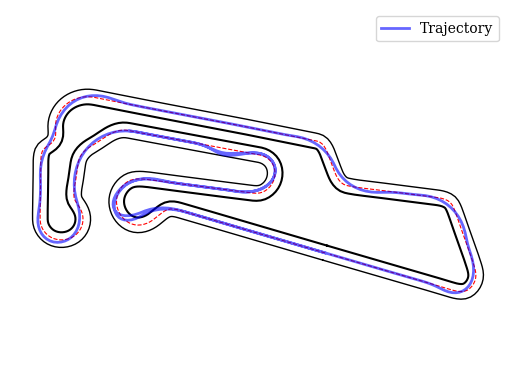

In [175]:
plt.figure()
plt.plot(state_history[0,:], state_history[1,:], 'b-', linewidth= 2, alpha =0.6, label = 'Trajectory')
ref_path.plot_track(linewidth = 1)
ref_path.plot_track_center(linewidth = 0.8, c='r')
plt.legend(prop={'size': 10})
plt.axis('equal')
plt.axis('off')
plt.show()

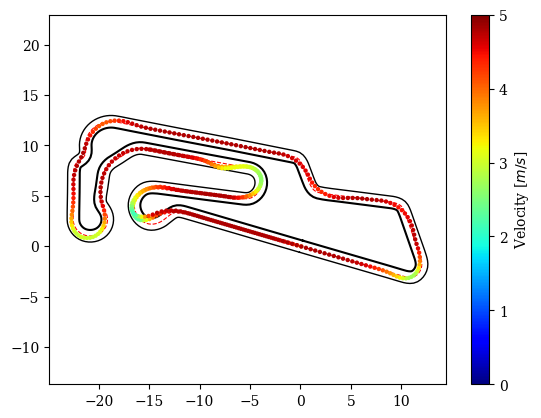

In [176]:
plt.figure()
ref_path.plot_track(linewidth = 1)
ref_path.plot_track_center(linewidth = 0.8, c='r')

sc = plt.scatter(state_history[0, :-1], state_history[1,:-1], s = 10, 
                c=state_history[2,:-1], cmap=cm.jet, 
                vmin=0, vmax=5, edgecolor='none', marker='o')
cbar = plt.colorbar(sc)
cbar.set_label(r"Velocity [$m/s$]", size=10)
plt.axis('equal')
plt.show()

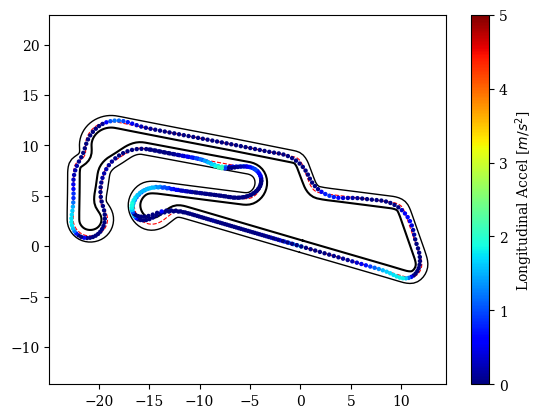

In [177]:
plt.figure()
ref_path.plot_track(linewidth = 1)
ref_path.plot_track_center(linewidth = 0.8, c='r')
sc = plt.scatter(state_history[0, :-1], state_history[1,:-1], s = 10, 
                c=control_history[0,:], cmap=cm.jet, 
                vmin=0, vmax=5, edgecolor='none', marker='o')
cbar = plt.colorbar(sc)
cbar.set_label(r"Longitudinal Accel [$m/s^2$]", size=10)
plt.axis('equal')
plt.show()

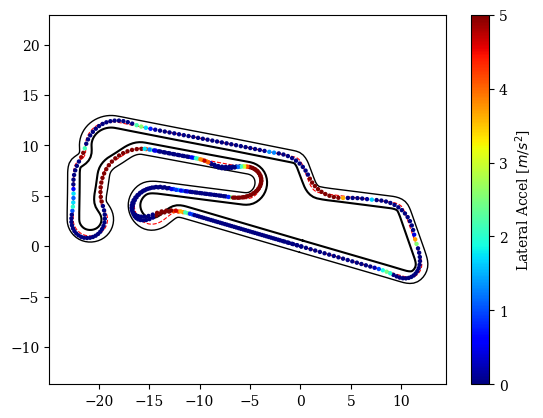

In [178]:
plt.figure()
ref_path.plot_track(linewidth = 1)
ref_path.plot_track_center(linewidth = 0.8, c='r')
alat = state_history[2,:]**2*np.tan(state_history[-1,:])/0.257
sc = plt.scatter(state_history[0, ], state_history[1,], s = 10, 
                c=alat, cmap=cm.jet, 
                vmin = 0, vmax=5, edgecolor='none', marker='o')
cbar = plt.colorbar(sc)
cbar.set_label(r"Lateral Accel [$m/s^2$]", size=10)
plt.axis('equal')
plt.show()

In [179]:
sim = plt.figure()
ref_path.plot_track()
plan_plot = plt.plot([], [], linewidth= 2)[0]
traj_plot = plt.scatter([], [], s = 10, c=[], cmap=cm.jet, vmin=0, vmax=5, edgecolor='none', marker='o')
cbar = plt.colorbar(traj_plot)
cbar.set_label(r"velocity [$m/s$]", size=20)
plt.axis('equal')
plt.close()

def drawframe(n):
    traj_plot.set_offsets(state_history[:2,:n+1].T)
    traj_plot.set_array(state_history[2,:n+1])
    plan_plot.set_data(plan_history[0,:, n], plan_history[1,:, n])
    
    return (traj_plot,plan_plot)


# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(sim, drawframe, frames=itr_receding, interval=ilqr.dt*1000, blit=True)
HTML(anim.to_html5_video())